In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,LabelEncoder
import matplotlib.pyplot as plt



2024-06-15 17:54:18.938517: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
train = pd.read_csv('./data/first_clean/train.csv')
train=train.set_index('Timestamp')
encoder=LabelEncoder()
train['Turbine_ID']=encoder.fit_transform(train['Turbine_ID'])
test = pd.read_csv('./data/first_clean/test.csv')
test=test.set_index('Timestamp')
test['Turbine_ID']=encoder.transform(test['Turbine_ID'])
reg_target_name = "RUL (Target)"
class_target_name = "Failure (Target)"
X_train = train.drop(columns=[class_target_name,'components'])
X_test= test.drop(columns=[class_target_name,'components'])
y_failure_train=train[class_target_name]
y_failure_test=test[class_target_name]
#y_component_train=train['components']
#y_component_test=test['components']

In [4]:
scaler=StandardScaler()
X_train_scalled=scaler.fit_transform(X_train)
X_test_scalled=scaler.transform(X_test)

In [8]:
input_dim = X_train_scalled.shape[1]

# Define the encoder layers
encoder = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(input_dim,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu')
])

# Define the decoder layers
decoder = tf.keras.models.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape=(16,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(input_dim, activation='linear')
])

# Combine encoder and decoder to create autoencoder
autoencoder = tf.keras.models.Sequential([encoder, decoder])

# Compile the autoencoder
autoencoder.compile(optimizer='adam', loss='mse')

In [9]:
X_non_faulty = X_train_scalled[y_failure_train == 0]

# Train the autoencoder
autoencoder.fit(X_non_faulty, X_non_faulty,
                epochs=50,
                batch_size=32,
                shuffle=True,
                validation_data=(X_test_scalled, X_test_scalled))

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.8042 - val_loss: 0.5245
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4025 - val_loss: 0.4347
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2998 - val_loss: 0.3581
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2564 - val_loss: 0.2981
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2328 - val_loss: 0.2525
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1844 - val_loss: 0.2239
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1636 - val_loss: 0.1965
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1463 - val_loss: 0.1791
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1401 - val_loss: 0.1643
Epoch 10/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1180 - val_loss: 0.1503
Epoch 11/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1250 - val_loss: 0.1420
Epoch 12/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1123 - val_lo

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


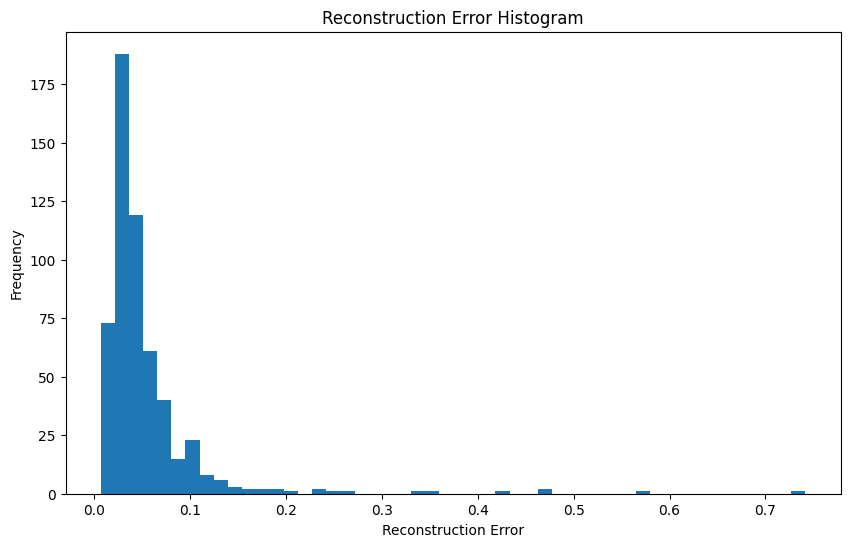

Precision: 0.75
Recall: 0.08
F1 Score: 0.14


In [10]:
# Reconstruct data using the autoencoder
reconstructed_data = autoencoder.predict(X_test_scalled)

# Calculate reconstruction error (MSE) for each sample
mse = np.mean(np.power(X_test_scalled - reconstructed_data, 2), axis=1)

# Plot the reconstruction error to visualize anomalies
plt.figure(figsize=(10, 6))
plt.hist(mse, bins=50)
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.title("Reconstruction Error Histogram")
plt.show()

# Set a threshold for anomaly detection (e.g., based on percentile or visual inspection)
threshold = np.percentile(mse, 95)  # Example: 95th percentile

# Predict anomalies
y_pred = mse > threshold

# Evaluate performance (e.g., F1 score, precision, recall)
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1_score, _ = precision_recall_fscore_support(y_failure_test, y_pred, average='binary')

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1_score:.2f}")
